# **CAPITULO II: INTEGRALES**

En este capitulo veremos la implementación paralela de algunos metodos para aproximar el calculo de integrales

### **Metodo de Newton o metodo del trapecio**

El metodo de newton se puede ampliar, dada:
$$\int_{a}^{b} \! f(x) \, dx$$
y considerando **n** intervalos, todos de la misma longitud $$h= \frac{b-a}{n}$$ 
se tiene que:
$$\int_{a}^{b} \! f(x) \, dx \approx \frac{h}{2}\left[\! f(a)+2\sum_{k=1}^{n-1} \! f(x_k)+ \! f(b)\right]$$
donde:
$$x_0 = a$$
$$x_k = a + k\times h$$
$$x_n = b$$

Veamos el siguiente ejemplo, se tiene la siguiente función:
$$\! f(x)=x^3-6x^2+11x-6$$
con la grafica correspondiente

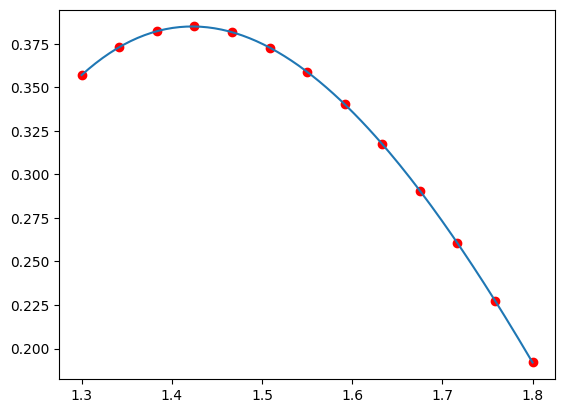

In [9]:
'''
ref. https://www.youtube.com/watch?v=T454EAQcWR8&t=419s
'''
import numpy as np 
import matplotlib.pyplot as plt

fx = lambda x: x**3 - 6*x**2 + 11*x - 6
a = 1.3
b = 1.8
muestras = 12

xi = np.linspace(a, b, muestras + 1)
fi = fx(xi)

mLinea = (muestras + 1) * 10
xk = np.linspace(a, b, mLinea)
fk = fx(xk)

plt.plot(xi, fi, 'ro')
plt.plot(xk, fk)


plt.show()


Podemos dividir en **n = 12** intervalos de la siguiente forma

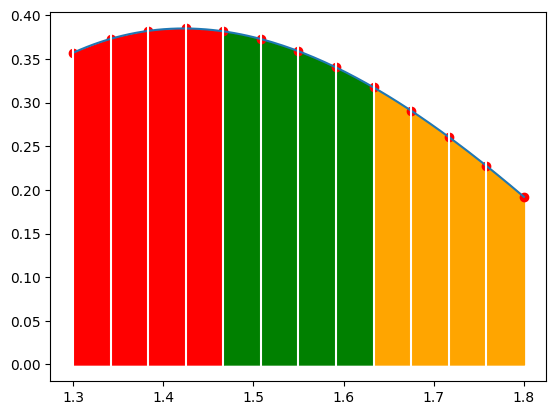

In [21]:
plt.plot(xi, fi, 'ro')
plt.plot(xk, fk)
plt.fill_between(xi[0:5], 0, fi[0:5], color='r', interpolate=True)

plt.fill_between(xi[4:9], 0, fi[4:9], color='g', interpolate=True)

plt.fill_between(xi[8:13], 0, fi[8:13], color='orange', interpolate=True)

for i in range(muestras):
    plt.axvline(xi[i], color='w')
plt.show()

Cada conjunto de intervalos será evaluado por un hilo en este caso **p = 3** hilos donde:

* El hilo **p = 0** evaluará en conjunto rojo.
* El hilo **p = 1** evaluará en conjunto verde.
* El hilo **p = 2** evaluará en conjunto rojo.

Ahora veamos la version secuencial del método de Newton.

In [63]:
%%writefile trapecioSecuencial.cpp
#include <stdio.h>

double f(double x){return x*x*x - 6*x*x + 11*x - 6;}

double trapecio(double a, double b, int n){
    //--# [a, b] es el intervalo
    //--# n el número de intervalos
    double h = (b - a)/n;
    double suma = (f(a) + f(b))/2.0;
    for (int k = 1; k < n - 1; k++){
        double xk = a + k * h;
        suma += f(xk);
    }
    double integral = h * suma;
    return integral;
}

int main(){
    //--# Intervalo
    double a = 1.3;
    double b = 1.8;
    
    //--# número de intervalos
    int intervalos = 100000;
    
    //--# calculo de la integral
    double integral = trapecio(a, b, intervalos);
    printf("la integral es: %.20lf", integral);
    return 0;
}

Overwriting trapecioSecuencial.cpp


In [64]:
!g++ trapecioSecuencial.cpp
!a.exe

la integral es: 0.16537403997518585000


para verificar el resultado lo haremos con la ayuda de python

In [70]:
import sympy as sp

x = sp.symbols('x')
f = x**3 - 6*x**2 + 11*x - 6

print(f'la integral es: {sp.integrate(f, (x, a, b))}')

la integral es: 0.165374999999999


La integral calculada por el metodo de trapecio es 0.165374... con n = 100000 intervalos y la integral real es 0.165375.

Ahora implementaremos la version paralela.

In [65]:
%%writefile trapecioParalelo.cpp
#include <stdio.h>
#include <omp.h>

double f(double x){return x*x*x - 6*x*x + 11*x - 6;}

void trapecioParalelo(double a, double b, int n, double *result_global){
    int thread = omp_get_thread_num();
    int threads = omp_get_num_threads();
    
    double h = (b - a)/n;
    
    //--# [a_local, b_local] es el intervalo
    //--# n_local el número de intervalos por hilo
    int n_local = n / threads;
    double a_local = a + thread * n_local * h;
    double b_local = a_local + n_local * h;
    
    double result_local = (f(a_local) + f(b_local))/2.0;
    for (int k = 1; k < n_local; k++){
        double xk = a_local + k * h;
        result_local += f(xk);
    }
    result_local *= h;
    #pragma omp critical
    *result_global += result_local;
}


int main(){
    //--# variable de integral total
    double result = 0.0;
    
    //--# variable que almacena el total de hilos a utilizar
    int threads = 4;
    
    //--# Declaramos el arreglo 
    double a = 1.3;
    double b = 1.8;
    int intervalos = 240000;
    
#pragma omp parallel num_threads(threads)
{
    trapecioParalelo(a, b, intervalos, &result);
}
    printf("la integral es : %.20lf", result);
    return 0;
}

Overwriting trapecioParalelo.cpp


In [66]:
!g++ -fopenmp trapecioParalelo.cpp
!a.exe

la integral es : 0.16537499999951197000
